# EC-Reliance Demo Notebook - Interferometry
# **3) Exploiting Results** Notebook
This Notebook enables the access to the output data produced by the **s1-insar-0_3_13** service (through **2) S1-SLC Service Execution** Notebook), which is stored on the remote S3 storage.

# Set-up

In [13]:
from urllib.parse import urlparse
from pystac import StacIO
from pystac.stac_io import DefaultStacIO
import boto3
import botocore
from collections import namedtuple
import pystac

import os 
import sys
import json

import requests
from requests.auth import HTTPBasicAuth
from pystac import *
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import getpass 
from osgeo import gdal

**Matplotlib**

In [14]:
a_min = 0; a_max = 255

In [15]:
%matplotlib inline

**StacIO**: Define customised class for **StacIO**, for reading a STAC catalog:

In [16]:
class CustomStacIO(DefaultStacIO):
    def __init__(self):

        session = boto3.session.Session()

        self.s3 = session.client(
            service_name="s3",
            region_name=settings.region_name,
            use_ssl=True,
            endpoint_url=f"https://{settings.endpoint_url}",
            aws_access_key_id=settings.aws_access_key_id,
            aws_secret_access_key=settings.aws_secret_access_key,
        )
        
    def read_text(self, source, *args, **kwargs):
        parsed = urlparse(source)
        if parsed.scheme == "s3":
            bucket = parsed.netloc
            key = parsed.path[1:]

            return (
                self.s3.get_object(Bucket=bucket, Key=key)["Body"]
                .read()
                .decode("utf-8")
            )
        else:
            return super().read_text(source, *args, **kwargs)

    def write_text(self, dest, txt, *args, **kwargs):
        parsed = urlparse(dest)
        if parsed.scheme == "s3":
            bucket = parsed.netloc
            key = parsed.path[1:]
            self.s3.put_object(
                Body=txt.encode("UTF-8"),
                Bucket=bucket,
                Key=key,
                ContentType="application/geo+json",
            )
        else:
            super().write_text(dest, txt, *args, **kwargs)

StacIO.set_default(CustomStacIO)
StacIO.read_text_method = CustomStacIO.read_text # this is to set the pystac.read_file() method

**S3 Settings**\
Prompt for user's credentials:

In [17]:
access_key = getpass.getpass('access_key:') 
secret_key = getpass.getpass('secret_key:') 

access_key: ································
secret_key: ································


In [18]:
S3Settings = namedtuple(
    "S3Settings",
    ["region_name", "endpoint_url", "aws_access_key_id", "aws_secret_access_key"],
    defaults=["", "", None, None],
)

settings = S3Settings(region_name='fr-par',
                      endpoint_url='labitaas.man.poznan.pl:7480',
                      aws_access_key_id=access_key, 
                      aws_secret_access_key=secret_key)
# settings

**GDAL** configuration parameters

In [19]:
# gdal config parameters
gdal.SetConfigOption('AWS_REGION', settings.region_name)
gdal.SetConfigOption('AWS_ACCESS_KEY_ID', settings.aws_access_key_id)
gdal.SetConfigOption('AWS_SECRET_ACCESS_KEY', settings.aws_secret_access_key)
gdal.SetConfigOption('AWS_S3_ENDPOINT', settings.endpoint_url)
gdal.SetConfigOption('AWS_HTTPS', 'YES')
gdal.SetConfigOption('AWS_VIRTUAL_HOSTING', 'FALSE')

# Accessing Results

**Job ID**: Define job remote location, using the ```job_id``` generated in the 2nd Notebook **ServiceExecution.ipynb**, and the bucket name.

In [28]:
job_id = input('Job ID:') # 187e5a96-fc51-11ec-9e1c-ce14506f56ef (New Ref-Sec pair); or 6a1b90ca-f94b-11ec-b6bb-ce14506f56ef (Old Ref-Sec pair)

wf_code = f'wf-{job_id}'

bucket_name = 'eoepca-ades-psnc'
uri = f's3://{bucket_name}/{wf_code}/catalog.json'
parsed = urlparse(uri)
parsed

Job ID: 187e5a96-fc51-11ec-9e1c-ce14506f56ef


ParseResult(scheme='s3', netloc='eoepca-ades-psnc', path='/wf-187e5a96-fc51-11ec-9e1c-ce14506f56ef/catalog.json', params='', query='', fragment='')

Read ***catalog.json*** with PySTAC

In [29]:
# Read the catalog.json file 
catalog = pystac.read_file(uri) # or catalog = Catalog.from_file(uri)
catalog.describe()

* <Catalog id=catalog>
  * <Item id=insar>


Show Item's Assets


In [22]:
# Show Item's Assets
item = next(catalog.get_items())
item.get_assets()

{'overview-coherence': <Asset href=./overview-coh_c_vv_20190628_20190710.tif>,
 'legend-overview-coherence': <Asset href=./legend-overview-coh_c_vv_20190628_20190710.png>,
 'coh_c_vv_20190628_20190710': <Asset href=./coh_c_vv_20190628_20190710.tif>,
 'overview-phase': <Asset href=./overview-phase_c_vv_20190628_20190710.tif>,
 'legend-overview-phase': <Asset href=./legend-overview-phase_c_vv_20190628_20190710.png>,
 'phase_c_vv_20190628_20190710': <Asset href=./phase_c_vv_20190628_20190710.tif>,
 'overview-displacement': <Asset href=./overview-displacement_c_vv_20190628_20190710.tif>,
 'legend-overview-displacement': <Asset href=./legend-overview-displacement_c_vv_20190628_20190710.png>,
 'displacement_c_vv_20190628_20190710': <Asset href=./displacement_c_vv_20190628_20190710.tif>}

# Visualising Results
We are going to plot the following result products:
* ```overview-coherence```
* ```overview-phase```
* ```overview-displacement```

If the data is stored on a AWS S3 bucket, we need to convert it to ```vsis3```, which is a file system handler that allows on-the-fly random reading, using ```gdal```, of (primarily non-public) files available in AWS S3 buckets, without prior download of the entire file. 

Working on: overview-coherence
S3 location: s3://eoepca-ades-psnc/wf-187e5a96-fc51-11ec-9e1c-ce14506f56ef/insar/overview-coh_c_vv_20190628_20190710.tif
VSIS3 location: /vsis3/eoepca-ades-psnc/wf-187e5a96-fc51-11ec-9e1c-ce14506f56ef/insar/overview-coh_c_vv_20190628_20190710.tif


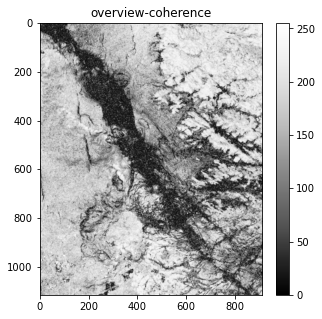


Working on: overview-phase
S3 location: s3://eoepca-ades-psnc/wf-187e5a96-fc51-11ec-9e1c-ce14506f56ef/insar/overview-phase_c_vv_20190628_20190710.tif
VSIS3 location: /vsis3/eoepca-ades-psnc/wf-187e5a96-fc51-11ec-9e1c-ce14506f56ef/insar/overview-phase_c_vv_20190628_20190710.tif


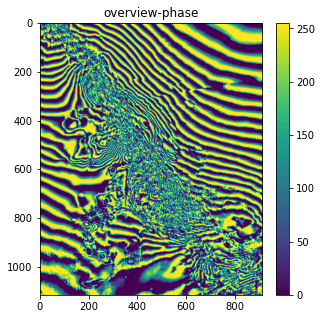


Working on: overview-displacement
S3 location: s3://eoepca-ades-psnc/wf-187e5a96-fc51-11ec-9e1c-ce14506f56ef/insar/overview-displacement_c_vv_20190628_20190710.tif
VSIS3 location: /vsis3/eoepca-ades-psnc/wf-187e5a96-fc51-11ec-9e1c-ce14506f56ef/insar/overview-displacement_c_vv_20190628_20190710.tif


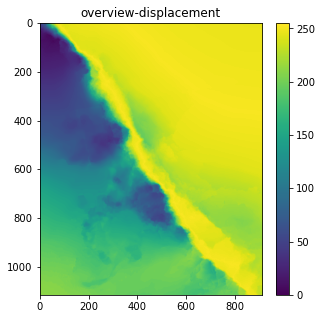


This ends this tutorial. Congrats! :-)


In [23]:
labels = ['overview-coherence', 'overview-phase', 'overview-displacement']

for label in labels:
    print('Working on:', label)
    
    # Get item Assets
    ov = item.get_assets()[label]

    # Convert location from S3 to VSIS3
    print(f'S3 location: {ov.get_absolute_href()}')

    parsed = urlparse(ov.get_absolute_href())
    if parsed.scheme == 's3': 
        ov.href = ov.get_absolute_href().replace('s3://', '/vsis3/')

    print(f'VSIS3 location: {ov.href}')
    
    # Open file with gdal and read bands
    ov_ds = gdal.Open(ov.href)
    bands = ov_ds.ReadAsArray()

    # Plot Image
    plt.figure(figsize=(5,5)); plt.title(label)
    if label == 'overview-coherence': plt.imshow(bands[0], norm=colors.Normalize(a_min, a_max), cmap=plt.get_cmap('Greys_r'))
    else: plt.imshow(bands[0], norm=colors.Normalize(a_min, a_max))
    plt.colorbar()
    plt.show()

    print('')
    
print('This ends this tutorial. Congrats! :-)')